In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython import display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from collections import namedtuple, deque
import random
import math
import pandas as pd

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
env_filter = namedtuple('env_filter',
                        ('state', 'action', 'next_state', 'reward'))

In [5]:
class replay_bank(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def store(self, state, action, next_state, reward):
        self.memory.append(env_filter(state, action, next_state, reward))

    def recall(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def printout(self):
        print(self.memory)

    def __len__(self):
        return len(self.memory)

In [6]:
class DQN(nn.Module):

    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(state_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, action_size)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [7]:
class agent:
    
    def __init__(self, env):
        
        self.env = env
        
        self.action_size = env.action_space.n
        self.state , _ = env.reset()

        self.state_size = len(self.state)

        self.batch_size = 16

        self.learning_rate = 1e-4

        self.gamma = 0.95
        self.epsilon = 0.9
        self.epsilon_min = 0.05
        self.epsilon_decay = 1000

        self.tau = 0.005
        
        self.memory = replay_bank(10000)
        
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.learning_rate)
        self.criterion = nn.SmoothL1Loss()
        
        self.steps_done = 0
        
        self.loss_list = []
        self.loss_avg = []
        self.max_q = float('-inf')
        self.max_q_vals = []
        
    def remember(self, state, action, next_state, reward):
        self.memory.store(state, action, next_state, reward)
        
    def show_memory(self):
        self.memory.print()
    
        '''
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return torch.tensor(random.randrange(self.action_size), device=device, dtype=torch.long).max()
        state_tensor = torch.tensor(state).to(device)
        action = self.policy_net(state).max(1)[1].view(1, 1)
        return action
    '''
    def act(self, state):
        sample = random.random()
        eps_threshold = self.epsilon_min + (self.epsilon - self.epsilon_min) * \
            math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        
    def log(self, loss, max_q):
        self.loss_list.append(loss)
        self.loss_avg.append(np.mean(self.loss_list[-100:]))
        self.max_q_vals.append(max_q)
        
    def learn(self):
        
        if len(self.memory) < self.batch_size:
            return
        
        recall = self.memory.recall(self.batch_size)
        
        bank = env_filter(*zip(*recall))
        state_bank = torch.cat(bank.state).to(device)
        #print(state_bank.size())
        
        action_bank = torch.cat(bank.action).to(device)
        #print(action_bank.size())
        reward_bank = torch.cat(bank.reward)
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          bank.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in bank.next_state
                                                if s is not None])
        
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        expected_vals = (next_state_values * self.gamma) + reward_bank
        
        action_vals = self.policy_net(state_bank).gather(1, action_bank)
        self.max_q = max(self.max_q, torch.max(action_vals))
        

        #print(action_vals)
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        loss = self.criterion(action_vals, expected_vals.unsqueeze(1))
        
        self.log(loss.cpu().detach().numpy(),self.max_q.cpu().detach().numpy())
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 1)
        self.optimizer.step()
        
        
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
        self.target_net.load_state_dict(target_net_state_dict)
        
        
        
        

In [8]:
env = gym.make("CartPole-v0")

cartpole_agent = agent(env)

max_target = 195

episode_lengths = []
length_avg = []

count = 0
cooldown = 0
episodes = 0

num_episodes = 10000

for episode in range(num_episodes):
    
    state, info = env.reset()
    state = torch.tensor(state).to(device).unsqueeze(0)
    
    cooldown -=1
    
    for t in range(200):
        
        action = cartpole_agent.act(state)
        #print(action)
        frame, reward, done, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(frame, dtype=torch.float32, device=device).unsqueeze(0)

            
        cartpole_agent.remember(state, action, next_state, reward)
        
        state = next_state
        
        cartpole_agent.learn()
        
        if done or truncated:
            
            episode_lengths.append(t + 1)
            if (episode + 1) % 100 == 0:
                print("-"*50)
                print(f"Episode {episode+1} finished after {t} time steps.")
                print(f"Episode {episode+1} average time per 100: {np.mean(episode_lengths[-100:])} time steps.")
                print("-"*50)
            break 
            
    
    #print(t)
    #print(cooldown)

    if t >= max_target and cooldown <= 0:
        
        #print(count)
        
        count +=1
        
        if count >= 5:
        
            cooldown = 10

            print(f"Testing on episode {episode +1}")

            test_lengths = []

            for test_count in range(100):
                state,_ = env.reset()
                state = torch.tensor(state).to(device).unsqueeze(0)
                for t in range(1, 1000): 
                    action  = cartpole_agent.act(state)
                    state, reward, done, truncated, _ = env.step(action.item())
                    state = torch.tensor(state).to(device).unsqueeze(0)

                    if done or truncated:
                        #print(f"Episode {episode + 1} finished after {t} time steps.")
                        test_lengths.append(t)
                        break

            test_average = sum(test_lengths) / 100
            print(f"Test on episode {episode +1}: Average per 100 = {test_average}")

            if test_average >= 195:
                
                rollout = []
                
                for episode in range(500):
                    state, _ = env.reset()
                    state = torch.tensor(state).to(device).unsqueeze(0)
                    frames = []
                    for t in range(1, 1000): 
                        action = cartpole_agent.act(state)
                        state, reward, done, truncated, _ = env.step(action.item())
                        state = torch.tensor(state).to(device).unsqueeze(0)
                        if done or truncated:
                            rollout.append(t)
                            break
                
                print(f"500 episodes rolled out. Mean: {np.mean(rollout)} SD: {np.std(rollout)}")

                break
    else:
        count = 0

/nfs/home/dwm7542/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/nfs/home/dwm7542/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


--------------------------------------------------
Episode 100 finished after 33 time steps.
Episode 100 average time per 100: 14.63 time steps.
--------------------------------------------------
--------------------------------------------------
Episode 200 finished after 9 time steps.
Episode 200 average time per 100: 11.22 time steps.
--------------------------------------------------
--------------------------------------------------
Episode 300 finished after 148 time steps.
Episode 300 average time per 100: 17.75 time steps.
--------------------------------------------------
--------------------------------------------------
Episode 400 finished after 189 time steps.
Episode 400 average time per 100: 158.64 time steps.
--------------------------------------------------
--------------------------------------------------
Episode 500 finished after 170 time steps.
Episode 500 average time per 100: 162.14 time steps.
--------------------------------------------------
Testing on episo

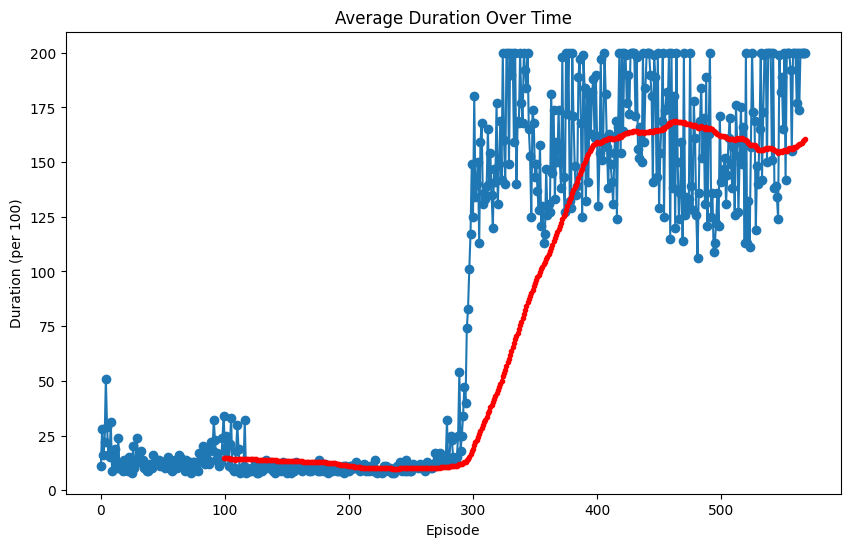

In [9]:
rolling_average = pd.Series(episode_lengths).rolling(window=100).mean()

plt.figure(figsize=(10, 6))
plt.plot(episode_lengths, marker='o', label = "Original")
plt.plot(rolling_average, marker='.', color='red', label='Rolling Average per 100')

plt.title('Average Duration Over Time')
plt.xlabel('Episode')
plt.ylabel('Duration (per 100)')
plt.savefig('results/cartpole_lengths.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

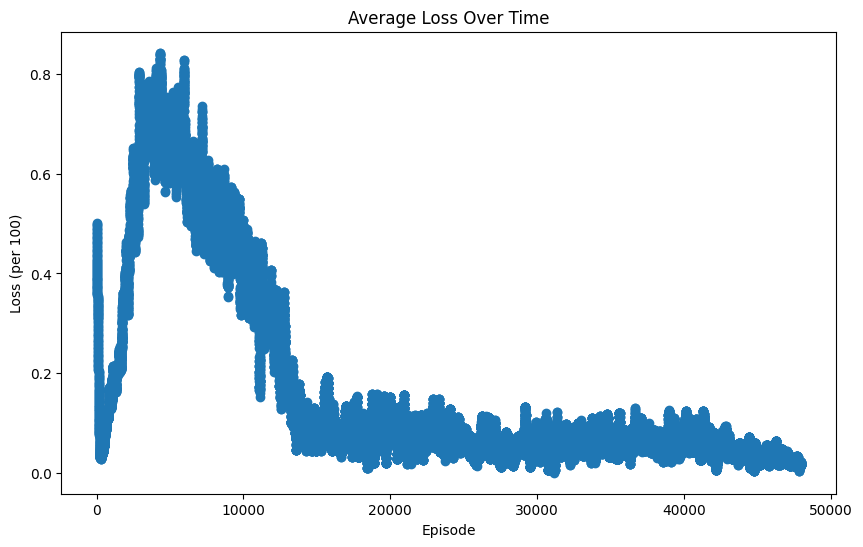

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(cartpole_agent.loss_avg, marker='o')

plt.title('Average Loss Over Time')
plt.xlabel('Episode')
plt.ylabel('Loss (per 100)')
plt.savefig('results/cartpole_loss.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

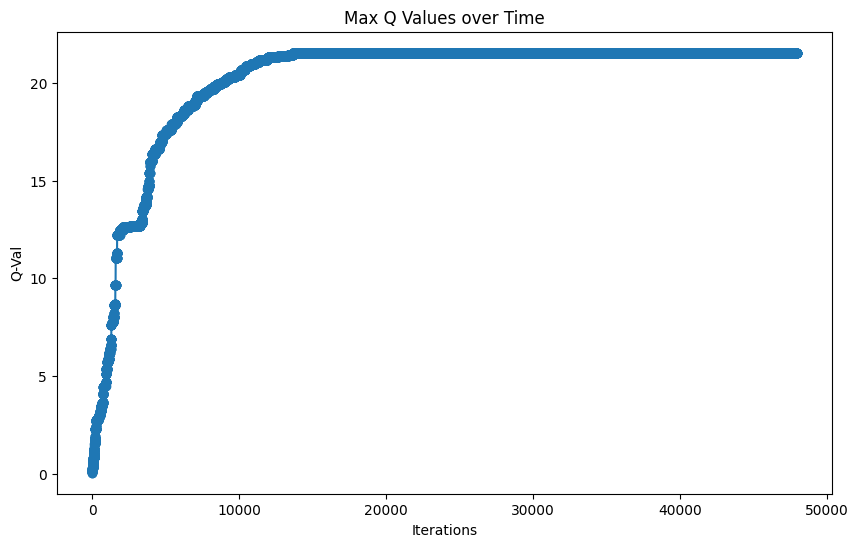

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(cartpole_agent.max_q_vals, marker='o')

plt.title('Max Q Values over Time')
plt.xlabel('Iterations')
plt.ylabel('Q-Val')
plt.savefig('results/cartpole_max_q.png', dpi=300, format='png', bbox_inches='tight')

plt.show()